# Sensitivity Analysis Example

Use `E.evaluate` to measure the effect of individual parameter quantisation and `S.LinearGradSqWrapper.wrap` to calculate the sum-grad-squared.

In [1]:
%env TOKENIZERS_PARALLELISM=true
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import torch
from torch import nn, Tensor, tensor
from typing import Iterable, Literal

import block_formats.experiments as E
import block_formats.fit as F
import block_formats.quantisation as Q
import block_formats.sensitivity as S

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env: TOKENIZERS_PARALLELISM=true


### Model loading

In [2]:
model = E.RequantisableModel.load("meta-llama/Llama-3.2-1B", DEVICE, torch.bfloat16)
data = E.Dataset.load_wikitext2(model.model, sequence_length=256, batch_size=16, kl_topk=128, sequence_limit=128)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [3]:
def evaluate_model() -> dict[str, float]:
    """Evaluate the current model and return (cross_entropy, cross_entropy_stderr, kl_div, kl_div_stderr) in a dict."""
    results = data.evaluate(model.model)
    return {k: v
            for metric, samples in results.items()
            for k, v in {
                metric: samples.mean().item(), f"{metric}_stderr": samples.std().item() / len(samples)**.5
            }.items()}

model.reset()
evaluate_model()

{'cross_entropy': 2.853245973587036,
 'cross_entropy_stderr': 0.029257428176485554,
 'kl_div': 0.0,
 'kl_div_stderr': 0.0}

### Empirical evaluation

In [ ]:
def sweep() -> Iterable[dict[str, float]]:
    for bits in [3, 4, 5]:
        for layer in [1, 8, 14]:  # subset for analysis & speed
            for name in [
                'self_attn.q_proj.weight',
                'self_attn.k_proj.weight',
                'self_attn.v_proj.weight',
                'self_attn.o_proj.weight',
                'mlp.gate_proj.weight',
                'mlp.up_proj.weight',
                'mlp.down_proj.weight',
            ]:
                parameter = f"model.layers.{layer}.{name}"
                model.reset()
                p = model.model.state_dict()[parameter]
                fmt = F.Scaled(bits, "fp", Q.BFLOAT16, (1, 64), scaling="absmax", compressor=None).fit(p)
                p[...] = fmt.quantise(p)

                yield dict(layer=layer, name=name, parameter=parameter, bits=bits, efmt=str(fmt.element_format), **evaluate_model())

df = pd.DataFrame.from_records(list(tqdm.tqdm(sweep())))
display(df.head())

0it [00:00, ?it/s]

63it [01:01,  1.03it/s]


,layer,name,parameter,bits,efmt,cross_entropy,cross_entropy_stderr,kl_div,kl_div_stderr
0,1,self_attn.q_proj.weight,model.layers.1.self_attn.q_proj.weight,3,E2M0,2.852269,0.029214,0.003172,0.000077
1,1,self_attn.k_proj.weight,model.layers.1.self_attn.k_proj.weight,3,E2M0,2.851326,0.029198,0.002654,0.000097
2,1,self_attn.v_proj.weight,model.layers.1.self_attn.v_proj.weight,3,E2M0,2.852507,0.029175,0.004493,0.000128
3,1,self_attn.o_proj.weight,model.layers.1.self_attn.o_proj.weight,3,E2M0,2.849124,0.029088,0.005898,0.000219
4,1,mlp.gate_proj.weight,model.layers.1.mlp.gate_proj.weight,3,E2M0,2.856274,0.029263,0.005987,0.000176


<Axes: xlabel='kl_div', ylabel='cross_entropy'>

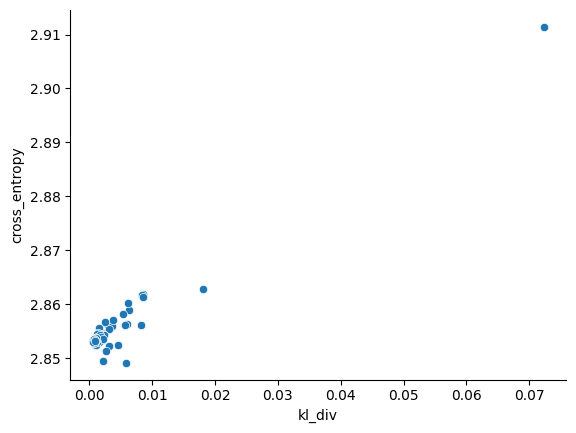

In [5]:
_, ax = plt.subplots()
sns.scatterplot(data=df, y="cross_entropy", x="kl_div", ax=ax)

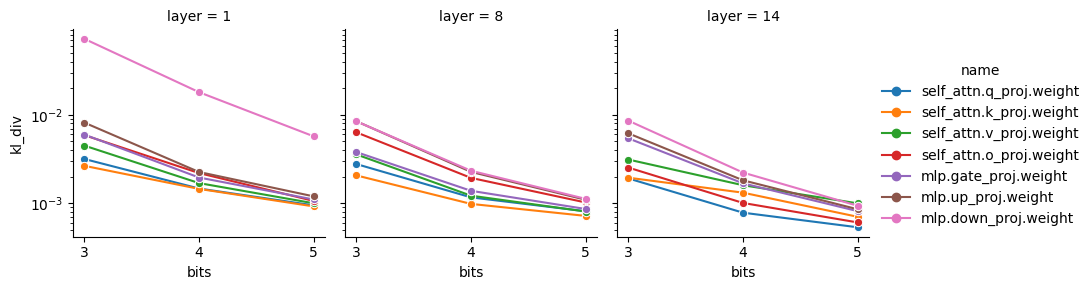

In [6]:
g = sns.relplot(data=df, y="kl_div", x="bits", hue="name", col="layer", marker="o", kind="line", height=3)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_xticks(df.bits.unique())

### Fisher-based sensitivity

In [ ]:
def calculate_sensitivity(model: nn.Module, loss: str, agg: Literal["mean", "sum"], progress: bool = False) -> dict[str, Tensor]:
    agg_fn = dict(mean=torch.mean, sum=torch.sum)[agg]
    S.LinearGradSqWrapper.wrap(model)
    try:
        model.zero_grad()
        for index in tqdm.tqdm(list(range(data.n_batch)), disable=not progress):
            losses = data.batch_losses(model, index)
            losses[loss].sum().backward()
        name_to_sensitivity = {}
        for name, m in model.named_modules():
            if isinstance(m, S.LinearGradSqWrapper):
                weight = m.wrapped.weight
                name_to_sensitivity[f"{name}.weight"] = agg_fn(weight.detach().square().mul_(weight.grad)).item()
    finally:
        S.LinearGradSqWrapper.unwrap(model)
        model.zero_grad()
    return name_to_sensitivity

model.reset()
# I thought agg="sum" is appropriate, since we're comparing against quantisation with fixed bits-per-element
# Note: should the sensitivity be calculated from "cross_entropy" not "kl_div"?
sensitivity = calculate_sensitivity(model.model, loss="kl_div", agg="sum", progress=True)

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


In [8]:
pd.DataFrame.from_records([dict(parameter=k, sensitivity=v) for k, v in sensitivity.items()])

,parameter,sensitivity
0,model.layers.0.self_attn.q_proj.weight,3.968180e-17
1,model.layers.0.self_attn.k_proj.weight,7.242471e-17
2,model.layers.0.self_attn.v_proj.weight,1.457168e-16
3,model.layers.0.self_attn.o_proj.weight,2.844947e-16
4,model.layers.0.mlp.gate_proj.weight,4.180684e-16
...,...,...
108,model.layers.15.self_attn.o_proj.weight,1.752071e-16
109,model.layers.15.mlp.gate_proj.weight,3.001072e-16
110,model.layers.15.mlp.up_proj.weight,3.694961e-16
111,model.layers.15.mlp.down_proj.weight,3.382711e-16


### Combine results

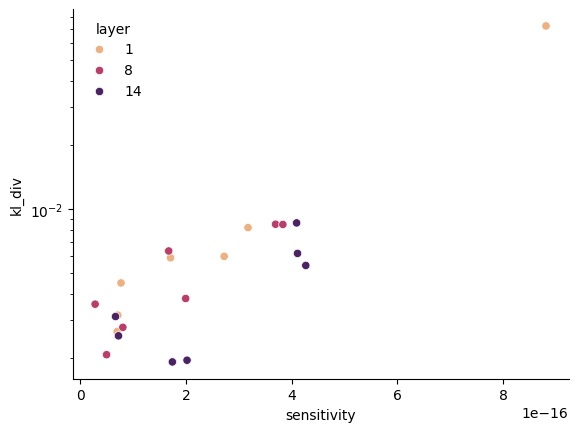

In [9]:
_, ax = plt.subplots()
sns.scatterplot(data=df.assign(sensitivity=df.parameter.apply(lambda p: sensitivity[p])).pipe(lambda d: d[d.bits == 3]),
                y="kl_div", x="sensitivity", hue="layer", palette="flare", ax=ax)
ax.set_yscale("log")